# 2SFCA script test at Middle Layer Super Output Areas (MSOA) level

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl

# Data import

## Get MSOA boundary data

In [20]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

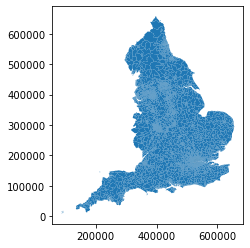

In [23]:
MSOA.plot()

## Get the centroid of MSOA (demand points)

In [3]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

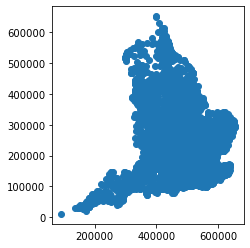

In [4]:
MSOA_points.plot()

In [6]:
MSOA_points

,objectid,msoa11cd,population,geometry
0,1,E02002536,9771,POINT (445582.345 524175.434)
1,2,E02002537,8641,POINT (446777.151 524256.841)
2,3,E02002534,5693,POINT (461356.929 515118.900)
3,4,E02002535,9336,POINT (446117.027 525455.836)
4,5,E02002532,6655,POINT (461053.212 516175.379)
...,...,...,...,...
6786,6787,E02004669,7496,POINT (393469.114 227500.260)
6787,6788,E02006096,7001,POINT (332829.367 109219.836)
6788,6789,E02003088,8444,POINT (343276.340 158947.520)
6789,6790,E02006070,8291,POINT (331710.269 136880.200)


## read vaccination site point data (supply points)

In [7]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

<AxesSubplot:>

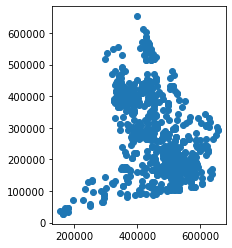

In [8]:
site.plot()

In [9]:
site

,index,hospital,pcn,pharmacy,vc,geometry
0,0,1,0,0,0,POINT (504748.029 248914.642)
1,1,1,0,0,0,POINT (505059.230 222903.988)
2,2,1,0,0,0,POINT (532504.110 176066.629)
3,3,1,0,0,0,POINT (532504.110 176066.629)
4,4,1,0,0,0,POINT (504396.617 222557.941)
...,...,...,...,...,...,...
1595,1595,0,0,0,1,POINT (196928.058 72385.978)
1596,1596,0,0,0,1,POINT (524814.936 172019.963)
1597,1597,0,0,0,1,POINT (526813.753 181129.037)
1598,1598,0,0,0,1,POINT (408626.628 90816.439)


# Calculate the Euclidean distance from demand to supply locations 

In [10]:
# Load each of the example datasets which correspond to the demand (population) and supply ('hospital','pcn','pharmacy','vc') respectively.
distance = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='population',
           supply_df= site,
           supply_index= 'index',
           supply_value=['hospital','pcn','pharmacy','vc'])
# reproject
distance.demand_df = distance.demand_df.to_crs('epsg:27700')
distance.supply_df = distance.supply_df.to_crs('epsg:27700')

In [12]:
# Take 150000 meters as the calculation threshold
distance.create_euclidean_distance(threshold = 150000)
distance.cost_df

access INFO     :: Overwriting euclidean.


,origin,dest,euclidean
0,E02004353,1302,383.594205
1,E02002506,127,775.943885
2,E02002506,137,604.627751
3,E02002505,127,905.825425
4,E02002502,844,862.029002
...,...,...,...
4843195,E02006679,1594,137289.304572
4843196,E02006679,1596,134570.497601
4843197,E02006679,1597,137481.247948
4843198,E02006679,1598,74203.111515


# Create a dataframe for the accessibility calculation using the Euclidean distance from the point of demand to the point of supply as cost

In [14]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='population',
           supply_df= site,
           supply_index= 'index',
           supply_value=['hospital','pcn','pharmacy','vc'],
           cost_df              = distance.cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean',
           neighbor_cost_df     = distance.cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'euclidean')

In [15]:
# Using 2SFCA method, 1e5 and 1e4 meters are used as service boundary radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca5",max_cost = 1e5)
fca.two_stage_fca(name = "2sfca4",max_cost = 1e4)

,2sfca4_hospital,2sfca4_pcn,2sfca4_pharmacy,2sfca4_vc
msoa11cd,,,,
E02000001,0.000029,0.000106,0.000019,1.444491e-05
E02000002,0.000003,0.000016,0.000004,5.123993e-07
E02000003,0.000003,0.000015,0.000004,5.123993e-07
E02000004,0.000002,0.000012,0.000002,5.123993e-07
E02000005,0.000003,0.000017,0.000004,1.620519e-06
...,...,...,...,...
E02006930,0.000017,0.000064,0.000014,1.005122e-05
E02006931,0.000018,0.000071,0.000017,1.122560e-05
E02006932,0.000010,0.000007,0.000001,0.000000e+00


## See the result

In [16]:
fca.access_df

,population,2sfca5_hospital,2sfca5_pcn,2sfca5_pharmacy,2sfca5_vc,2sfca4_hospital,2sfca4_pcn,2sfca4_pharmacy,2sfca4_vc
msoa11cd,,,,,,,,,
E02000001,9721,0.000008,0.000033,0.000007,4.093143e-06,0.000029,0.000106,0.000019,1.444491e-05
E02000002,7735,0.000008,0.000033,0.000007,4.330153e-06,0.000003,0.000016,0.000004,5.123993e-07
E02000003,11174,0.000008,0.000033,0.000007,4.330153e-06,0.000003,0.000015,0.000004,5.123993e-07
E02000004,6687,0.000008,0.000033,0.000007,4.330153e-06,0.000002,0.000012,0.000002,5.123993e-07
E02000005,10432,0.000008,0.000033,0.000007,4.330153e-06,0.000003,0.000017,0.000004,1.620519e-06
...,...,...,...,...,...,...,...,...,...
E02006930,9127,0.000008,0.000033,0.000007,4.204402e-06,0.000017,0.000064,0.000014,1.005122e-05
E02006931,9806,0.000008,0.000033,0.000007,4.204402e-06,0.000018,0.000071,0.000017,1.122560e-05
E02006932,17515,0.000003,0.000008,0.000002,5.325229e-07,0.000010,0.000007,0.000001,0.000000e+00


# Combine the two results into a standardized accessibility value based on the weight of the vaccination services of different type

In [17]:
fca.score(name = "2sfca5_combo", col_dict = {"2sfca5_hospital" : 0.25, "2sfca5_pcn" : 0.25,"2sfca5_pharmacy": 0.25, "2sfca5_vc": 0.25})
fca.score(name = "2sfca4_combo", col_dict = {"2sfca4_hospital" : 0.25, "2sfca4_pcn" : 0.25,"2sfca4_pharmacy": 0.25, "2sfca4_vc": 0.25})

msoa11cd
E02000001    6.077155
E02000002    0.741926
E02000003    0.695724
E02000004    0.495404
E02000005    0.889282
               ...   
E02006930    4.030325
E02006931    4.467631
E02006932    0.715192
E02006933    0.715192
E02006934    0.610102
Name: 2sfca4_combo, Length: 6791, dtype: float64

In [18]:
fca_combo = fca.access_df[['2sfca5_combo','2sfca4_combo']]
fca_combo

,2sfca5_combo,2sfca4_combo
msoa11cd,,
E02000001,1.871269,6.077155
E02000002,1.907436,0.741926
E02000003,1.907436,0.695724
E02000004,1.905555,0.495404
E02000005,1.908269,0.889282
...,...,...
E02006930,1.884992,4.030325
E02006931,1.880999,4.467631
E02006932,0.429558,0.715192


# Show the accessibility result on map

In [25]:
MSOA_fca = pd.merge(left=MSOA, right=fca_combo, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca

,MSOA11CD,MSOA11NM,population,geometry,2sfca5_combo,2sfca4_combo
0,E02000001,City of London 001,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",1.871269,6.077155
1,E02000002,Barking and Dagenham 001,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",1.907436,0.741926
2,E02000003,Barking and Dagenham 002,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",1.907436,0.695724
3,E02000004,Barking and Dagenham 003,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",1.905555,0.495404
4,E02000005,Barking and Dagenham 004,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",1.908269,0.889282
...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",1.884992,4.030325
6787,E02006931,Greenwich 038,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",1.880999,4.467631
6788,E02006932,Liverpool 060,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",0.429558,0.715192
6789,E02006933,Liverpool 061,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",0.426898,0.715192


check the distribution

<AxesSubplot:>

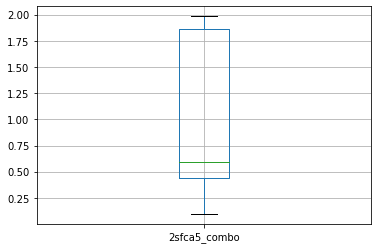

In [26]:
MSOA_fca.boxplot(column='2sfca5_combo')

<AxesSubplot:>

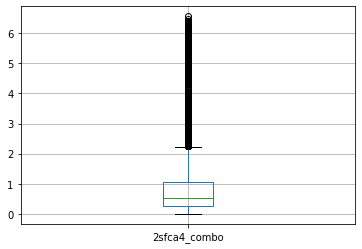

In [27]:
MSOA_fca.boxplot(column='2sfca4_combo')

In [34]:
def plot_access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

### When the service radius is 10000 meters:

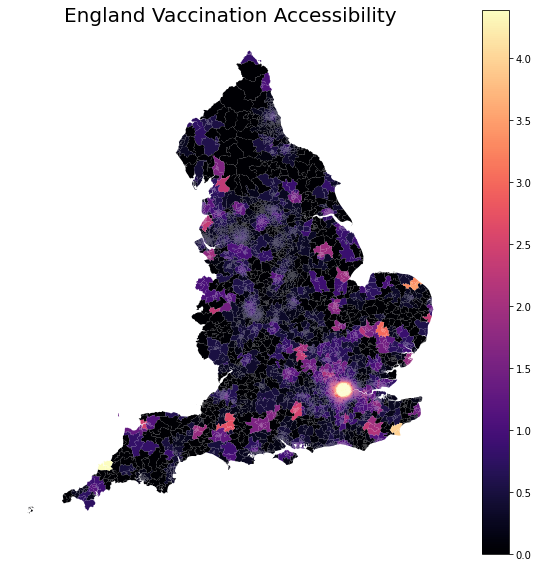

In [35]:
plot_access('2sfca4_combo')

### When the service radius is 100000 meters:

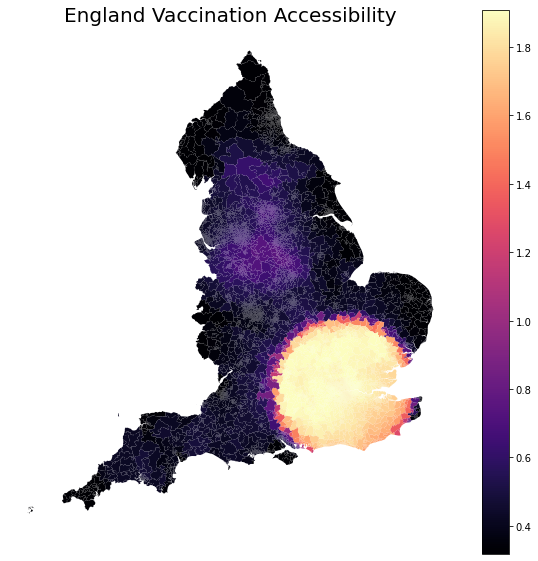

In [36]:
plot_access('2sfca5_combo')

## Another way to visulize

In [38]:
def combo(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False
        )

### When the service radius is 10000 meters:

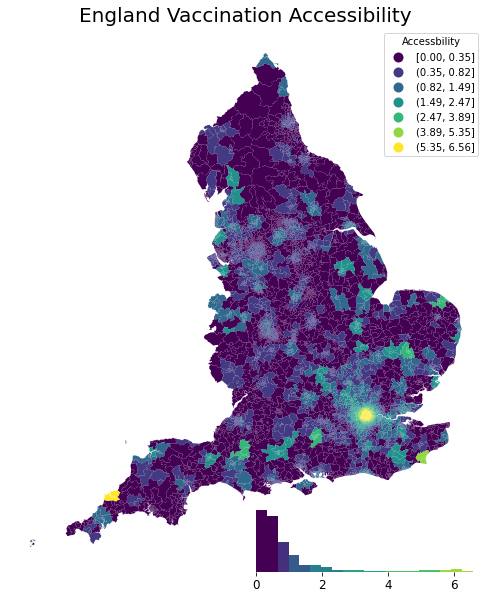

In [39]:
combo('2sfca4_combo')

### When the service radius is 100000 meters:

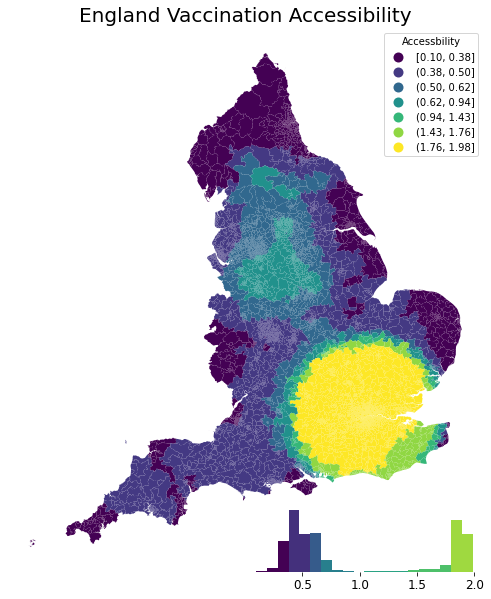

In [40]:
combo('2sfca5_combo')